
---------------------- RESULTS FOR N = 1000 ----------------------
Algorithm            | Build Time (s)     | Query Time (s)     | Memory (Bytes) 
--------------------------------------------------------------------------------
Simple               | 0.000002           | 0.053041           | 8856           
SparseTable          | 0.002560           | 0.002910           | 88808          
SegmentTree          | 0.000785           | 0.059950           | 32056          
BlockDecomp          | 0.000156           | 0.022461           | 320            
Creative             | 0.000319           | 0.012081           | 8696           

---------------------- RESULTS FOR N = 5000 ----------------------
Algorithm            | Build Time (s)     | Query Time (s)     | Memory (Bytes) 
--------------------------------------------------------------------------------
Simple               | 0.000002           | 0.216193           | 41880          
SparseTable          | 0.014354           | 0.002893  

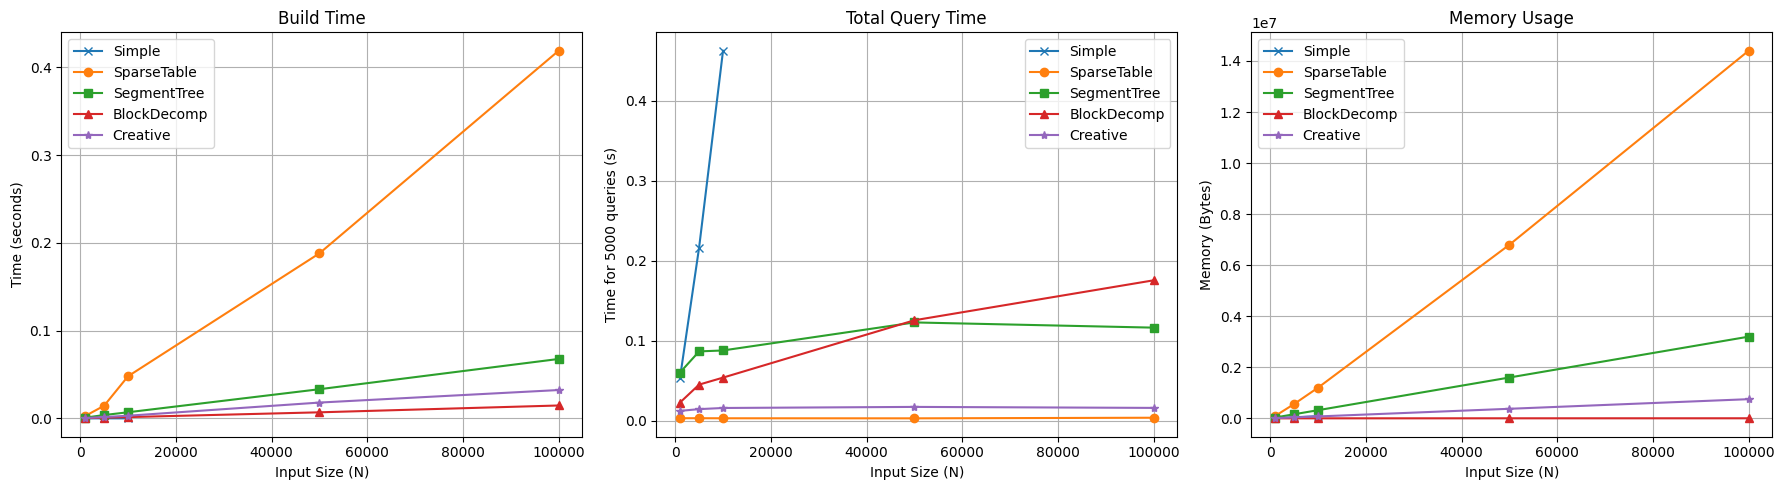

In [11]:
import sys
import math
import time
import random
import matplotlib.pyplot as plt

sys.setrecursionlimit(200000)

# The algorithm classes

# 1. Simple
class Simple:
    def __init__(self, data):
        self.raw_data = data
        self.data = []

    def build(self):
        self.data = self.raw_data 
        
    def query(self, left, right):
        return min(self.data[left:right+1])
    
    def get_memory_usage(self):
        # Just return the size of the reference list
        return sys.getsizeof(self.data)
        
# 2. Sparse Table
class SparseTable:
    def __init__(self, data):
        self.raw_data = data
        self.sparse_table = []
        self.logs = []
        self.n = 0
        self.k = 0

    def build(self):
        self.n = len(self.raw_data)
        if self.n == 0: return
        self.k = int(math.log2(self.n)) + 1
        self.sparse_table = [[0] * self.n for _ in range(self.k)]
        self.logs = [0] * (self.n + 1)
        
        for i in range(2, self.n + 1):
            self.logs[i] = self.logs[i >> 1] + 1
            
        for i in range(self.n):
            self.sparse_table[0][i] = self.raw_data[i]
            
        for j in range(1, self.k):
            range_len = 1 << (j - 1)
            for i in range(self.n - (1 << j) + 1):
                self.sparse_table[j][i] = min(self.sparse_table[j-1][i], self.sparse_table[j-1][i+range_len])

    def query(self, left, right):
        length = right - left + 1
        j = self.logs[length]
        return min(self.sparse_table[j][left], self.sparse_table[j][right - (1 << j) + 1])

    def get_memory_usage(self):
        # Calculate size of the 2D array (list of lists)
        total_size = sys.getsizeof(self.sparse_table)
        for row in self.sparse_table:
            total_size += sys.getsizeof(row)
        # Add size of logs array
        total_size += sys.getsizeof(self.logs)
        return total_size

# 3. Segment Tree
class SegmentTree:
    def __init__(self, data):
        self.raw_data = data
        self.n = 0
        self.tree = []

    def build(self):
        self.n = len(self.raw_data)
        if self.n == 0: return
        self.tree = [0] * (4 * self.n)
        self._build_recursive(self.raw_data, 1, 0, self.n - 1)

    def _build_recursive(self, data, node, start, end):
        if start == end:
            self.tree[node] = data[start]
        else:
            mid = (start + end) // 2
            self._build_recursive(data, 2 * node, start, mid)
            self._build_recursive(data, 2 * node+1, mid+1, end)
            self.tree[node] = min(self.tree[2 * node], self.tree[2*node+1])

    def query(self, left, right):
        return self._query_recursive(1, 0, self.n - 1, left, right)

    def _query_recursive(self, node, start, end, left, right):
        if right < start or end < left:
            return float('inf')
        if left <= start and end <= right:
            return self.tree[node]
        mid = (start + end) // 2
        p1 = self._query_recursive(2*node, start, mid, left, right)
        p2 = self._query_recursive(2*node+1, mid+1, end, left, right)
        return min(p1, p2)

    def get_memory_usage(self):
        # Return size of the tree array
        return sys.getsizeof(self.tree)

# 4. Block Decomposition
class BlockDecomposition:
    def __init__(self, data):
        self.data = data 
        self.n = len(data)
        self.blocks = []
        self.block_size = 0

    def build(self):
        self.block_size = int(math.sqrt(self.n))
        if self.block_size == 0: self.block_size = 1
        num_blocks = (self.n + self.block_size - 1) // self.block_size
        self.blocks = [float('inf')] * num_blocks
        
        for i in range(self.n):
            b_index = i // self.block_size
            if self.data[i] < self.blocks[b_index]:
                self.blocks[b_index] = self.data[i]

    def query(self, left, right):
        start_block = left // self.block_size
        end_block = right // self.block_size
        res = float('inf')
        
        if start_block == end_block:
            for i in range(left, right + 1):
                if self.data[i] < res: res = self.data[i]
        else:
            for i in range(left, (start_block + 1) * self.block_size):
                if self.data[i] < res: res = self.data[i]
            for b in range(start_block + 1, end_block):
                if self.blocks[b] < res: res = self.blocks[b]
            for i in range(end_block * self.block_size, right + 1):
                if self.data[i] < res: res = self.data[i]
        return res

    def get_memory_usage(self):
        # Return size of the blocks array
        return sys.getsizeof(self.blocks)

# 5. Creative (Bonus)
class Creative:
    def __init__(self, data):
        self.data = data
        self.n = len(data)
        self.block_mins = []
        self.summary_sparse_table = None
        self.block_size = 0

    def build(self):
        self.block_size = max(1, int(math.log2(self.n)))
        num_blocks = (self.n + self.block_size - 1) // self.block_size
        self.block_mins = [float('inf')] * num_blocks
        
        for i in range(self.n):
            b_index = i // self.block_size
            if self.data[i] < self.block_mins[b_index]:
                self.block_mins[b_index] = self.data[i]
        
        self.summary_sparse_table = SparseTable(self.block_mins)
        self.summary_sparse_table.build()

    def query(self, left, right):
        bl = left // self.block_size
        br = right // self.block_size
        
        if bl == br:
            m = self.data[left]
            for i in range(left + 1, right + 1):
                if self.data[i] < m: m = self.data[i]
            return m
            
        res = float('inf')
        limit_first = (bl + 1) * self.block_size
        for i in range(left, min(limit_first, right + 1)):
             if self.data[i] < res: res = self.data[i]
             
        start_last = br * self.block_size
        for i in range(start_last, right + 1):
            if self.data[i] < res: res = self.data[i]
            
        if bl + 1 <= br - 1:
            sparse_table_min = self.summary_sparse_table.query(bl + 1, br - 1)
            if sparse_table_min < res: res = sparse_table_min
        return res

    def get_memory_usage(self):
        # Size of blocks array + size of the internal sparse table
        base = sys.getsizeof(self.block_mins)
        internal = 0
        if self.summary_sparse_table:
            internal = self.summary_sparse_table.get_memory_usage()
        return base + internal


def run_experiments():
    input_sizes = [1000, 5000, 10000, 50000, 100000] 
    CONST_QUERIES = 5000
    
    algorithms = [
        ("Simple", Simple),
        ("SparseTable", SparseTable),
        ("SegmentTree", SegmentTree),
        ("BlockDecomp", BlockDecomposition),
        ("Creative", Creative)
    ]
    
    # Store the results for plot
    results = {name: {'sizes': [], 'build_time': [], 'query_time': [], 'memory': []} 
               for name, _ in algorithms}

    for n in input_sizes:
        # generate random data and queries for this N
        data = [random.randint(0, 10**9) for _ in range(n)]
        queries = []
        for _ in range(CONST_QUERIES):
            left = random.randint(0, n - 1)
            right = random.randint(0, n - 1)
            if left > right: left, right = right, left
            queries.append((left, right))
        
        print(f"\n---------------------- RESULTS FOR N = {n} ----------------------")
        print(f"{'Algorithm':<20} | {'Build Time (s)':<18} | {'Query Time (s)':<18} | {'Memory (Bytes)':<15}")
        print("-" * 80)
            
        for name, AlgoClass in algorithms:
            # if n>20000 running the simple algorithm can take a long time! so we skip it, if you want to also see the results of simple algorithm
            # for n>20000, simply comment this part:
            if name == "Simple" and n > 20000:
                continue

            obj = AlgoClass(data)

            # Measure Build Time
            t0 = time.perf_counter()
            obj.build()
            t1 = time.perf_counter()
            build_time = t1 - t0
            
            # Measure Query Time
            t2 = time.perf_counter()
            for left, right in queries:
                _ = obj.query(left, right)
            t3 = time.perf_counter()
            total_query_time = t3 - t2
            
            # Measure Memory
            mem_usage = obj.get_memory_usage()
            
            # Store results for plotting
            results[name]['sizes'].append(n)
            results[name]['build_time'].append(build_time)
            results[name]['query_time'].append(total_query_time)
            results[name]['memory'].append(mem_usage)
            
            print(f"{name:<20} | {build_time:<18.6f} | {total_query_time:<18.6f} | {mem_usage:<15}")

    return results

def plot_results(results):
    fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(18, 5))
    
    markers = {'Simple': 'x', 'SparseTable': 'o', 'SegmentTree': 's', 
               'BlockDecomp': '^', 'Creative': '*'}
    
    # Plot Build Time
    axis1.set_title("Build Time")
    axis1.set_xlabel("Input Size (N)")
    axis1.set_ylabel("Time (seconds)")
    for name, data in results.items():
        if data['sizes']:
            axis1.plot(data['sizes'], data['build_time'], marker=markers.get(name, '.'), label=name)
    axis1.legend()
    axis1.grid(True)
    
    # Plot Query Time
    axis2.set_title("Total Query Time")
    axis2.set_xlabel("Input Size (N)")
    axis2.set_ylabel(f"Time for {5000} queries (s)")
    for name, data in results.items():
        if data['sizes']:
            axis2.plot(data['sizes'], data['query_time'], marker=markers.get(name, '.'), label=name)
    axis2.legend()
    axis2.grid(True)
    
    # Plot Memory Usage
    axis3.set_title("Memory Usage")
    axis3.set_xlabel("Input Size (N)")
    axis3.set_ylabel("Memory (Bytes)")
    for name, data in results.items():
        if data['sizes']:
            axis3.plot(data['sizes'], data['memory'], marker=markers.get(name, '.'), label=name)
    axis3.legend()
    axis3.grid(True)
    
    plt.tight_layout()
    plt.show()

# main
if __name__ == "__main__":
    results = run_experiments()
    plot_results(results)